In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os

#Import Custom Classes

from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas
from Source.PER import PrioritizedReplayBuffer

In [3]:
#Hyper-parameters
BUFFER_SIZE = 8#int(1e5)      #replay buffer size
BATCH_SIZE = 8#128             #minibatch size
GAMMA = 0.999                #discount factor
ALPHA = 1.0                  #non-stationarity parameter
TAU = 1e-2#1e-1                  #for soft update of target parameters
LR = 1e-3                   #learning rate
TEST_EVERY = 1600            #how often to test the network
UPDATE_EVERY =1
eps_start = 1.0
eps_end = 0.5
eps_decay = 0.9981 #125e-6
PER_ALPHA = 0.6
PER_BETA = 0.4
PRIORITIZED_REPLAY = False



episodes = 4000 #3100 train, 500 test
seed = 0                    #random seed number
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inp_fptr = open("ricianch_variation.txt")
ch_randvals = inp_fptr.read().splitlines()
ch_randvals = [np.complex(a.replace('i','j')) for a in ch_randvals]

In [4]:
print(ch_randvals[0])

#print(np.complex(ch_randvals[0].replace('i','j')))

(1.1128+0.0082264j)


Beamset: [(0.39269908, 8) (0.78539816, 8) (1.17809725, 8) (1.57079633, 8)
 (1.96349541, 8) (2.35619449, 8) (2.74889357, 8) (3.14159265, 8)]
Bemset in deg: [(22.500000000000004, 8), (45.0, 8), (67.5, 8), (90.0, 8), (112.5, 8), (135.0, 8), (157.5, 8), (180.0, 8)]
Ntx: 8, active Ntx: 4, Beam: [ 0.35355339+0.j         -0.21414724-0.28132003j -0.09413548+0.34079101j
  0.32818294-0.13151411j -0.30342524-0.18147485j  0.03938632+0.3513527j
  0.25571266-0.24415371j -0.34915657-0.05558496j]


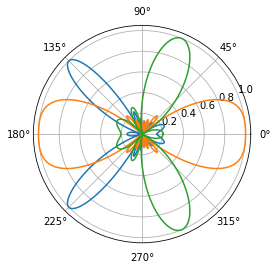

In [5]:
#Testing (beam_dir, beam_width) Beamset
from Source.antenna.ula import var_steervec
from Source.misc_fun.utils import Generate_Beams, var_plotbeam

width_vec = np.array([np.pi/8])
beamset = Generate_Beams(8,width_vec)

print("Beamset: {}".format(beamset))
print("Bemset in deg: {}".format([(x[0]*180/np.pi,x[1]) for x in beamset]))

tx_beam = var_steervec(8,beamset[5], 0)
print("Ntx: {}, active Ntx: {}, Beam: {}".format(8, 4, tx_beam))

theta, gr = var_plotbeam(beamset[5], 8)
theta2, gr2 = var_plotbeam(beamset[7], 8)
theta3, gr3 = var_plotbeam(beamset[2], 4)
ax = plt.subplot(111, projection='polar')
##print(theta.shape, gr.shape)
ax.plot(theta,gr, theta2, gr2, theta3,gr3)
plt.show()
    

In [6]:
#Choose the environment
em = EnvManager(device, 'combrf-v7', seed)
available_actions = em.num_actions_available()
random.seed(seed)
state_size = em.state_size()
print(em.env.ch_model)
print(em.env.sc_xyz)

#EPISODE length
min_episode_length = em.env.N_rx
max_episode_length = em.env.N_rx#em.env.N_rx
episode_delta = 1

#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 3500)

if PRIORITIZED_REPLAY:
    beta_strategy = EpsilonGreedyStrategy(PER_BETA, 1.0, eps_decay, 3500)

#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
if not PRIORITIZED_REPLAY:
    memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)
else:
    memory = PrioritizedReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, PER_ALPHA,seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
#optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)
optimizer = optim.SGD(params=policy_net.parameters(), lr=LR, momentum=0.9)

uma-los
[]
QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=4, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=64, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=64, out_features=16, bias=True)
)


In [7]:
print("tx_locs: {}".format(em.env.tx_locs))

tx_locs: [array([[-300. , -300. ,   21.5]]), array([[-300. , -200. ,   21.5]]), array([[-300. , -100. ,   21.5]]), array([[-200. , -300. ,   21.5]]), array([[-200. , -200. ,   21.5]]), array([[-200. , -100. ,   21.5]]), array([[-100. , -300. ,   21.5]]), array([[-100. , -200. ,   21.5]]), array([[-100. , -100. ,   21.5]])]


In [8]:
print("Beamset: {}".format(em.env.BeamSet))

Beamset: [(0.19634954, 16) (0.39269908, 16) (0.58904862, 16) (0.78539816, 16)
 (0.9817477 , 16) (1.17809725, 16) (1.37444679, 16) (1.57079633, 16)
 (1.76714587, 16) (1.96349541, 16) (2.15984495, 16) (2.35619449, 16)
 (2.55254403, 16) (2.74889357, 16) (2.94524311, 16) (3.14159265, 16)]


## Test with random untrained actions

obs = em.env.reset(np.exp(1j * 2 * np.pi * 0.6),0)
#print(len(em.env.beamwidth_vec))
#print(em.env.action_space.n)
print(obs)
ep_rwd=[]
while True:
    action = random.randrange(em.env.action_space.n)
    
    obs, rwd, done,_ = em.env.step(action)
    print(action)
    ep_rwd.append(rwd)
    if done:
        break
        
print("Episode score: {}".format(np.sum(ep_rwd)))

In [9]:
moving_rpts = [[np.array([rp_loc])] for rp_loc in em.env.sc_xyz]

#print("Initial: \n", moving_rpts)

for i in range(2):
    for ndx in range(len(moving_rpts)):
        if (ndx == 0) or (ndx == 1):
            last_loc = moving_rpts[ndx][-1]
            new_loc = np.array([[last_loc[0][0]+em.env.rx_stepsize, last_loc[0][1], last_loc[0][2]]]) 
            moving_rpts[ndx].append(new_loc)
        elif (ndx == 2) or (ndx == 3):
            last_loc = moving_rpts[ndx][-1]
            new_loc = np.array([[last_loc[0][0], last_loc[0][1]-em.env.rx_stepsize, last_loc[0][2]]]) 
            moving_rpts[ndx].append(new_loc)

print("After adding moving patterns: ", moving_rpts)



After adding moving patterns:  []


In [10]:
eps_scpts = []

for i in range(episodes):
    #print(random.choice(moving_rpts[0]))
    sc_pts = np.array([random.choice(moving_rpts[ndx])[0] for ndx in range(len(moving_rpts))])
    eps_scpts.append(sc_pts)

#print(eps_scpts)

In [11]:
print(eps_scpts[7])

[]


In [12]:
print(em.env.tx_locs)
print(len(em.env.tx_locs))

[array([[-300. , -300. ,   21.5]]), array([[-300. , -200. ,   21.5]]), array([[-300. , -100. ,   21.5]]), array([[-200. , -300. ,   21.5]]), array([[-200. , -200. ,   21.5]]), array([[-200. , -100. ,   21.5]]), array([[-100. , -300. ,   21.5]]), array([[-100. , -200. ,   21.5]]), array([[-100. , -100. ,   21.5]])]
9


In [13]:
print(em.env.sc_xyz)
print(em.env.ch_model)

[]
uma-los


## Train the DQN agent

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [2, 1, 3, 0, 4, 15, 5, 14, 6, 13, 7, 12, 8, 11, 9, 10], prevep_bestaction: 2
action: 2, reward: -1.0, rate: 6.960820483978678, best_rate: 9.076694747140605
action: 1, reward: 1.0, rate: 9.076694747140605, best_rate: 9.076694747140605
action: 3, reward: 0.0, rate: 6.80237433317256, best_rate: 9.076694747140605
action: 0, reward: 1.0, rate: 10.53836858495281, best_rate: 10.53836858495281
action: 4, reward: 0.0, rate: 7.216954850682484, best_rate: 10.53836858495281
action: 15, reward: 1.0, rate: 11.307172781321604, best_rate: 11.307172781321604
action: 5, reward: 0.0, rate: 10.107642420359943, best_rate: 11.307172781321604
action: 14, reward: 1.0, rate: 11.350228723620935, best_rate: 11.350228723620935
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 11.350228723620935
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 11.350228723620935
action: 7, reward: 0.0, rate: 10.809347340348182, bes

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [2, 1, 3, 0, 4, 15, 5, 14, 6, 13, 7, 12, 8, 11, 9, 10], prevep_bestaction: 2
action: 2, reward: 1.0, rate: 8.810154904263793, best_rate: 8.810154904263793
action: 1, reward: 0.0, rate: 6.692828650277245, best_rate: 8.810154904263793
action: 3, reward: 0.0, rate: 8.804607677656136, best_rate: 8.810154904263793
action: 0, reward: 1.0, rate: 10.610787521507635, best_rate: 10.610787521507635
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 10.610787521507635
action: 15, reward: 1.0, rate: 10.868504470115871, best_rate: 10.868504470115871
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 10.868504470115871
action: 14, reward: 0.0, rate: 10.422306311766544, best_rate: 10.868504470115871
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 10.868504470115871
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 10.868504470115871
action: 7, reward: 1.0, rate: 12.635102094850032, best

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [2, 1, 3, 0, 4, 15, 5, 14, 6, 13, 7, 12, 8, 11, 9, 10], prevep_bestaction: 2
action: 2, reward: 1.0, rate: 10.205366811606774, best_rate: 10.205366811606774
action: 1, reward: 0.0, rate: 5.850302512747961, best_rate: 10.205366811606774
action: 3, reward: 0.0, rate: 9.710644264577434, best_rate: 10.205366811606774
action: 0, reward: 1.0, rate: 11.749360246110529, best_rate: 11.749360246110529
action: 4, reward: 0.0, rate: 6.490409491472517, best_rate: 11.749360246110529
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 11.749360246110529
action: 5, reward: 0.0, rate: 8.869565064993099, best_rate: 11.749360246110529
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 11.749360246110529
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 11.749360246110529
action: 13, reward: 1.0, rate: 11.87542188629878, best_rate: 11.87542188629878
action: 7, reward: 0.0, rate: 9.530218875287975, be

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [2, 1, 3, 0, 4, 15, 5, 14, 6, 13, 7, 12, 8, 11, 9, 10], prevep_bestaction: 2
action: 2, reward: -1.0, rate: 12.547379025863956, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 3, reward: 0.0, rate: 11.386988291555408, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 4, reward: 0.0, rate: 5.074981261116849, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 5, reward: 0.0, rate: 10.58422383216516, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 6, reward: 0.0, rate: 8.303962687588058, best_rate: 18.320943816541163
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 7, reward: 0.0, rate: 10.4048588366763

Episode 25,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 12, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 2.014329195022583

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [2, 1, 3, 0, 4, 15, 5, 14, 6, 13, 7, 12, 8, 11, 9, 10], prevep_bestaction: 2
action: 2, reward: -1.0, rate: 8.810154904263793, best_rate: 17.018607412917714
action: 1, reward: 0.0, rate: 6.692828650277245, best_rate: 17.018607412917714
action: 3, reward: 0.0, rate: 8.804607677656136, best_rate: 17.018607412917714
action: 0, reward: 0.0, rate: 10.610787521507635, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 15, reward: 0.0, rate: 10.868504470115871, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_r

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [15, 14, 0, 13, 1, 12, 2, 11, 3, 10, 4, 9, 5, 8, 6, 7], prevep_bestaction: 15
action: 15, reward: -1.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 13, reward: 0.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.41542086730743, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 2, reward: 0.0, rate: 11.506821540870183, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 3, reward: 0.0, rate: 10.752014419471148, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 4, reward: 0.0, rate: 7.30258682

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [0, 15, 1, 14, 2, 13, 3, 12, 4, 11, 5, 10, 6, 9, 7, 8], prevep_bestaction: 0
action: 0, reward: -1.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_rate: 19.33900226313412
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 3, reward: 0.0, rate: 11.47019014192813, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 4, reward: 0.0, rate: 12.256497735263425, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 5, reward: 0.0, rate: 10.548015463745418, best_r

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [0, 15, 1, 14, 2, 13, 3, 12, 4, 11, 5, 10, 6, 9, 7, 8], prevep_bestaction: 0
action: 0, reward: -1.0, rate: 11.749360246110529, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 1, reward: 0.0, rate: 5.850302512747961, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 2, reward: 0.0, rate: 10.205366811606774, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 3, reward: 0.0, rate: 9.710644264577434, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 4, reward: 0.0, rate: 6.490409491472517, best_rate: 17.575976489996886
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 5, reward: 0.0, rate: 8.8695650649930

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.749360246110529, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 1, reward: 0.0, rate: 5.850302512747961, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 2, reward: 0.0, rate: 10.205366811

action: 2, reward: 0.0, rate: 13.679690738859776, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 3, reward: 0.0, rate: 13.185159891031857, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 4, reward: 0.0, rate: 9.918704499394615, best_rate: 21.062009545682816
action: 5, reward: 0.0, rate: 12.364029602916567, best_rate: 21.062009545682816
tx_loc:[[-100.  -100.    21.5]], tx-dir:0 not converged until episode: 56
Episode 56,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 13, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 2.00809383392334

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate:

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.626744269607132, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 15, reward: 0.0, rate: 12.302273922496308, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 0, reward: 0.0, rate: 12.23263396053

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
action: 12, reward: -1.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, best_rate: 17.018607412917714
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 15, reward: 0.0, rate: 10.868504470115871, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 0, reward: 0.0, rate: 10.610787521507635, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 1, reward: 0.0, rate: 6.6928286502772

Episode 86,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 9, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 2.004646062850952

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 7, reward: 0.0, rate: 9.833811451146975, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 6, reward: 0.0, rate: 8.763651918222061, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 5, reward: 0.0, rate: 9.527572334344981, best_rate: 18.092278003135895
action: 13, reward: 0.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 4, reward: 0.0, rate: 7.302586824994302, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.626744269607132, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 15, reward: 0.0, rate: 12.302273922496308, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 0, reward: 0.0, rate: 12.23263396053

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

Episode 116,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.3499999940395355, current_best action: 13, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 2.005002737045288

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.53836858495281, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 1, reward: 0.0, rate: 9.0

action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.547379025863956, best_rate: 18.320943816541163
action: 7, reward: 0.0, rate: 10.404858836676345, best_rate: 18.320943816541163
action: 3, reward: 0.0, rate: 11.386988291555408, best_rate: 18.320943816541163
action: 6, reward: 0.0, rate: 8.303962687588058, best_rate: 18.320943816541163
action: 4, reward: 0.0, rate: 5.074981261116849, best_rate: 18.320943816541163
action: 5, reward: 0.0, rate: 10.58422383216516, best_rate: 18.320943816541163
Episode 122,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.3700000047683716, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 1.003440260887146

TX Location: [[-100.  -300.    21.5

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 7, reward: 0.0, rate: 10.404858836676345, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 6, reward: 0.0, rate: 8.303962687588058, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.8003687838

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.626744269607132, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 15, reward: 0.0, rate: 12.302273922496308, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 0, reward: 0.0, rate: 12.23263396053

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.53836858495281, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 1, reward: 0.0, rate: 9.076694747140605, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 2, reward: 0.0, rate: 6.9608204839786

action: 14, reward: 0.0, rate: 11.626744269607132, best_rate: 18.217089704737734
action: 3, reward: 0.0, rate: 10.543675551934546, best_rate: 18.217089704737734
action: 15, reward: 0.0, rate: 12.302273922496308, best_rate: 18.217089704737734
action: 2, reward: 0.0, rate: 10.691787700275407, best_rate: 18.217089704737734
action: 0, reward: 0.0, rate: 12.232633960532656, best_rate: 18.217089704737734
action: 1, reward: 0.0, rate: 5.500184286804422, best_rate: 18.217089704737734
Episode 146,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.3799999952316284, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 1.0040667057037354

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 1

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 5, reward: 0.0, rate: 10.107642420359943, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 4, reward: 0.0, rate: 7.216954850682484, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.3502287236209

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 5, reward: 0.0, rate: 12.364029602916567, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 4, reward: 0.0, rate: 9.918704499394615, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868

Episode 162,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.38999998569488525, current_best action: 10, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 2.006070137023926

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.3

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 5, reward: 0.0, rate: 8.869565064993099, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.55430824947

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 7, reward: 0.0, rate: 9.451347633295997, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 6, reward: 0.0, rate: 10.920546130484446, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.626744269607132, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 15, reward: 0.0, rate: 12.302273922496308, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 0, reward: 0.0, rate: 12.23263396053

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 5, reward: 0.0, rate: 10.156286527054162, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 4, reward: 0.0, rate: 7.761029344657838, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.7238288485

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

Episode 216,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.49000000953674316, current_best action: 13, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 2.00919246673584

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.626744269607132, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 15, reward: 0.0, rate: 12.

Episode 222,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5199999809265137, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 1.0035837888717651

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486218751, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 1, reward: 0.0, rate

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 5, reward: 0.0, rate: 10.156286527054162, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 4, reward: 0.0, rate: 7.761029344657838, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.7238288485

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.53836858495281, best_rate: 18.092123711855802
action: 5, reward: 0.0, rate: 10.107642420359943, best_rate: 18.092123711855802
action: 1, reward: 0.0, rate: 9.076694747140605, best_rate: 18.092123711855802
action: 4, reward: 0.0, rate: 7.216954850682484, best_rate: 18.092123711855802
action: 2, reward: 0.0, rate: 6.960820483978678, best_rate: 18.092123711855802
action: 3, reward: 0.0, rate: 6.80237433317256, best_rate: 18.092123711855802
tx_loc:[[-200.  -300.    21.5]], tx-dir:0 not converged until episode: 240
Episode 240,	Score: 0.00, eps: 0.5, moving avg_rwd

Episode 246,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.550000011920929, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 1.0037654638290405

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 7, reward: 0.0, rate: 10.404858836676345, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.41542086730743, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 2, reward: 0.0, rate: 11.506821540

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.626744269607132, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 15, reward: 0.0, rate: 12.302273922496308, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 0, reward: 0.0, rate: 12.23263396053

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 13, reward: 0.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 7, reward: 0.0, rate: 9.833811451146975, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 6, reward: 0.0, rate: 8.763651918222061, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

Episode 312,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.5799999833106995, current_best action: 11, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 2.0046656131744385

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

Episode 324,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.5600000023841858, current_best action: 13, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 2.0051345825195312

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.005

Episode 330,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.550000011920929, current_best action: 10, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 2.0059890747070312

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 5, reward: 0.0, rate: 10.156286527054162, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 4, reward: 0.0, rate: 7.761029344657838, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.7238288485

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

action: 3, reward: 0.0, rate: 13.185159891031857, best_rate: 21.062009545682816
Episode 354,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5299999713897705, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 1.0039836168289185

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

Episode 372,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.5400000214576721, current_best action: 9, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 2.006500005722046

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 5, reward: 0.0, rate: 10.156286527054162, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.1

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.41542086730743, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 2, reward: 0.0, rate: 11.506821540

action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.547379025863956, best_rate: 18.320943816541163
action: 7, reward: 0.0, rate: 10.404858836676345, best_rate: 18.320943816541163
action: 3, reward: 0.0, rate: 11.386988291555408, best_rate: 18.320943816541163
action: 6, reward: 0.0, rate: 8.303962687588058, best_rate: 18.320943816541163
action: 4, reward: 0.0, rate: 5.074981261116849, best_rate: 18.320943816541163
action: 5, reward: 0.0, rate: 10.58422383216516, best_rate: 18.320943816541163
Episode 414,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.47999998927116394, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 1.0039385557174683

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.0620

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 13, reward: 0.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 7, reward: 0.0, rate: 9.833811451146975, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 6, reward: 0.0, rate: 8.763651918222061, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 5, reward: 0.0, rate: 10.107642420359943, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 4, reward: 0.0, rate: 7.216954850682484, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.3502287236209

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.749360246110529, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 1, reward: 0.0, rate: 5.850302512747961, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 2, reward: 0.0, rate: 10.205366811

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 13, reward: 0.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 7, reward: 0.0, rate: 9.833811451146975, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.4154208673

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 13, reward: 0.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 7, reward: 0.0, rate: 9.833811451146975, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.4154208673

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 13, reward: 0.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 7, reward: 0.0, rate: 9.833811451146975, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.4154208673

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 5, reward: 0.0, rate: 10.156286527054162, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 4, reward: 0.0, rate: 7.761029344657838, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.7238288485

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 7, reward: 0.0, rate: 10.404858836676345, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 6, reward: 0.0, rate: 8.303962687588058, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.8003687838

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 7, reward: 0.0, rate: 9.451347633295997, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 6, reward: 0.0, rate: 10.920546130484446, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 5, reward: 0.0, rate: 10.107642420359943, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 4, reward: 0.0, rate: 7.216954850682484, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.3502287236209

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 5, reward: 0.0, rate: 10.107642420359943, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 4, reward: 0.0, rate: 7.216954850682484, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.3502287236209

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 7, reward: 0.0, rate: 10.404858836676345, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 6, reward: 0.0, rate: 8.303962687588058, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.8003687838

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486218751, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 1, reward: 0.0, rate: 7.107668482122316, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 2, reward: 0.0, rate: 11.48977559

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.41542086730743, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 2, reward: 0.0, rate: 11.506821540

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.41542086730743, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 2, reward: 0.0, rate: 11.506821540

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 7, reward: 0.0, rate: 9.451347633295997, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 6, reward: 0.0, rate: 10.920546130484446, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 7, reward: 0.0, rate: 9.451347633295997, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 6, reward: 0.0, rate: 10.920546130484446, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 5, reward: 0.0, rate: 10.107642420359943, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 4, reward: 0.0, rate: 7.216954850682484, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.3502287236209

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.749360246110529, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 1, reward: 0.0, rate: 5.850302512747961, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 2, reward: 0.0, rate: 10.205366811

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 7, reward: 0.0, rate: 9.451347633295997, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 6, reward: 0.0, rate: 10.920546130484446, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 5, reward: 0.0, rate: 10.156286527054162, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 4, reward: 0.0, rate: 7.761029344657838, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.7238288485

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.41542086730743, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 2, reward: 0.0, rate: 11.506821540

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 13, reward: 0.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 7, reward: 0.0, rate: 9.833811451146975, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 6, reward: 0.0, rate: 8.763651918222061, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 5, reward: 0.0, rate: 10.107642420359943, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.30717278132

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486218751, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 1, reward: 0.0, rate: 7.107668482122316, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 2, reward: 0.0, rate: 11.48977559

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 5, reward: 0.0, rate: 8.869565064993099, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.55430824947

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 7, reward: 0.0, rate: 9.451347633295997, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 6, reward: 0.0, rate: 10.920546130484446, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.41542086730743, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 2, reward: 0.0, rate: 11.506821540

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 13, reward: 0.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 7, reward: 0.0, rate: 9.833811451146975, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 6, reward: 0.0, rate: 8.763651918222061, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.233494621767115, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 1, reward: 0.0, rate: 9.218267586703975, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 2, reward: 0.0, rate: 13.6796907

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.233494621767115, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 1, reward: 0.0, rate: 9.218267586703975, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 2, reward: 0.0, rate: 13.6796907

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.233494621767115, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 1, reward: 0.0, rate: 9.218267586703975, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 2, reward: 0.0, rate: 13.6796907

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 5, reward: 0.0, rate: 12.364029602916567, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 4, reward: 0.0, rate: 9.918704499394615, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.749360246110529, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 1, reward: 0.0, rate: 5.850302512747961, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 2, reward: 0.0, rate: 10.205366811

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 7, reward: 0.0, rate: 9.451347633295997, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 6, reward: 0.0, rate: 10.920546130484446, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.749360246110529, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 1, reward: 0.0, rate: 5.850302512747961, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 2, reward: 0.0, rate: 10.205366811

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 5, reward: 0.0, rate: 10.107642420359943, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 4, reward: 0.0, rate: 7.216954850682484, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.3502287236209

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 7, reward: 0.0, rate: 10.404858836676345, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 6, reward: 0.0, rate: 8.303962687588058, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.8003687838

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 5, reward: 0.0, rate: 12.364029602916567, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 4, reward: 0.0, rate: 9.918704499394615, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 13, reward: 0.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 7, reward: 0.0, rate: 9.833811451146975, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 6, reward: 0.0, rate: 8.763651918222061, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 7, reward: 0.0, rate: 9.451347633295997, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 6, reward: 0.0, rate: 10.920546130484446, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.41542086730743, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 2, reward: 0.0, rate: 11.506821540

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.626744269607132, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 15, reward: 0.0, rate: 12.302273922496308, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 0, reward: 0.0, rate: 12.23263396053

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 7, reward: 0.0, rate: 9.451347633295997, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 6, reward: 0.0, rate: 10.920546130484446, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 5, reward: 0.0, rate: 10.107642420359943, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 4, reward: 0.0, rate: 7.216954850682484, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.3502287236209

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.626744269607132, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 15, reward: 0.0, rate: 12.302273922496308, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 0, reward: 0.0, rate: 12.23263396053

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 5, reward: 0.0, rate: 12.364029602916567, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 4, reward: 0.0, rate: 9.918704499394615, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.41542086730743, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 2, reward: 0.0, rate: 11.506821540

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 21.062009545682816, best_rate: 21.062009545682816
action: 10, reward: 0.0, rate: 15.828947490115372, best_rate: 21.062009545682816
action: 12, reward: 0.0, rate: 4.716361071237707, best_rate: 21.062009545682816
action: 9, reward: 0.0, rate: 15.008180303524384, best_rate: 21.062009545682816
action: 13, reward: 0.0, rate: 15.345959840526747, best_rate: 21.062009545682816
action: 8, reward: 0.0, rate: 10.460979188727324, best_rate: 21.062009545682816
action: 14, reward: 0.0, rate: 13.938422868340792, best_rate: 21.062009545682816
action: 7, reward: 0.0, rate: 13.022363180983286, best_rate: 21.062009545682816
action: 15, reward: 0.0, rate: 15.045603345517806, best_rate: 21.062009545682816
action: 6, reward: 0.0, rate: 11.751292018560557, best_rate: 21.062009545682816
action: 0, reward: 0.0, rate: 15.2334946

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 13, reward: 0.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 7, reward: 0.0, rate: 9.833811451146975, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 6, reward: 0.0, rate: 8.763651918222061, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 7, reward: 0.0, rate: 9.451347633295997, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 6, reward: 0.0, rate: 10.920546130484446, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.41542086730743, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 2, reward: 0.0, rate: 11.506821540

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 5, reward: 0.0, rate: 11.430108917104697, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 4, reward: 0.0, rate: 3.9696323075405155, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.62674426960713

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 18.320943816541163, best_rate: 18.320943816541163
action: 12, reward: 0.0, rate: 10.705900041039245, best_rate: 18.320943816541163
action: 14, reward: 0.0, rate: 18.188599636644224, best_rate: 18.320943816541163
action: 11, reward: 0.0, rate: 8.89606389696611, best_rate: 18.320943816541163
action: 15, reward: 0.0, rate: 17.660126321595293, best_rate: 18.320943816541163
action: 10, reward: 0.0, rate: 9.707871893496748, best_rate: 18.320943816541163
action: 0, reward: 0.0, rate: 16.800368783800046, best_rate: 18.320943816541163
action: 9, reward: 0.0, rate: 11.228621155959242, best_rate: 18.320943816541163
action: 1, reward: 0.0, rate: 7.185837602210498, best_rate: 18.320943816541163
action: 8, reward: 0.0, rate: 3.845508725467313, best_rate: 18.320943816541163
action: 2, reward: 0.0, rate: 12.54737902586

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486218751, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 1, reward: 0.0, rate: 7.107668482122316, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 2, reward: 0.0, rate: 11.48977559

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 7, reward: 0.0, rate: 9.451347633295997, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 6, reward: 0.0, rate: 10.920546130484446, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 7, reward: 0.0, rate: 9.451347633295997, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 6, reward: 0.0, rate: 10.920546130484446, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.53836858495281, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 1, reward: 0.0, rate: 9.076694747140605, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 2, reward: 0.0, rate: 6.9608204839786

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.53836858495281, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 1, reward: 0.0, rate: 9.076694747140605, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 2, reward: 0.0, rate: 6.9608204839786

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486218751, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 1, reward: 0.0, rate: 7.107668482122316, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 2, reward: 0.0, rate: 11.48977559

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 5, reward: 0.0, rate: 10.156286527054162, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 4, reward: 0.0, rate: 7.761029344657838, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.7238288485

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 5, reward: 0.0, rate: 10.156286527054162, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 4, reward: 0.0, rate: 7.761029344657838, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.7238288485

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.626744269607132, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 15, reward: 0.0, rate: 12.302273922496308, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 0, reward: 0.0, rate: 12.23263396053

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 19.33900226313412, best_rate: 19.33900226313412
action: 12, reward: 0.0, rate: 18.29405255332316, best_rate: 19.33900226313412
action: 14, reward: 0.0, rate: 16.81918475968656, best_rate: 19.33900226313412
action: 11, reward: 0.0, rate: 15.18169069108526, best_rate: 19.33900226313412
action: 15, reward: 0.0, rate: 14.604061375784553, best_rate: 19.33900226313412
action: 10, reward: 0.0, rate: 12.887147742109315, best_rate: 19.33900226313412
action: 0, reward: 0.0, rate: 0.6321363466445902, best_rate: 19.33900226313412
action: 9, reward: 0.0, rate: 8.970379178595053, best_rate: 19.33900226313412
action: 1, reward: 0.0, rate: 15.234283280439293, best_rate: 19.33900226313412
action: 8, reward: 0.0, rate: 11.816469568034684, best_rate: 19.33900226313412
action: 2, reward: 0.0, rate: 12.51526315003478, best_

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.626744269607132, best_rate: 18.217089704737734
action: 11, reward: 0.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 15, reward: 0.0, rate: 12.302273922496308, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 0, reward: 0.0, rate: 12.232633960532656, best_rate: 18.217089704737734
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 1, reward: 0.0, rate: 5.500184286804422, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 2, reward: 0.0, rate: 10.69178770027

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: 1.0, rate: 17.018607412917714, best_rate: 17.018607412917714
action: 8, reward: 0.0, rate: 8.598257788283911, best_rate: 17.018607412917714
action: 10, reward: 0.0, rate: 9.560695010165347, best_rate: 17.018607412917714
action: 7, reward: 0.0, rate: 12.635102094850032, best_rate: 17.018607412917714
action: 11, reward: 0.0, rate: 9.3776196665665, best_rate: 17.018607412917714
action: 6, reward: 0.0, rate: 7.79360038247478, best_rate: 17.018607412917714
action: 12, reward: 0.0, rate: 8.608764239167005, best_rate: 17.018607412917714
action: 5, reward: 0.0, rate: 10.72516801797474, best_rate: 17.018607412917714
action: 13, reward: 0.0, rate: 8.608787582163247, best_rate: 17.018607412917714
action: 4, reward: 0.0, rate: 3.449701666939587, best_rate: 17.018607412917714
action: 14, reward: 0.0, rate: 10.422306311766544, be

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 14.818202917233142, best_rate: 18.092278003135895
action: 12, reward: 1.0, rate: 18.092278003135895, best_rate: 18.092278003135895
action: 14, reward: 0.0, rate: 12.653803344689855, best_rate: 18.092278003135895
action: 11, reward: 0.0, rate: 0.22173827266882357, best_rate: 18.092278003135895
action: 15, reward: 0.0, rate: 13.608396775032688, best_rate: 18.092278003135895
action: 10, reward: 0.0, rate: 11.196388526652978, best_rate: 18.092278003135895
action: 0, reward: 0.0, rate: 13.66574378787198, best_rate: 18.092278003135895
action: 9, reward: 0.0, rate: 11.21256337818095, best_rate: 18.092278003135895
action: 1, reward: 0.0, rate: 7.41542086730743, best_rate: 18.092278003135895
action: 8, reward: 0.0, rate: 7.079163574837376, best_rate: 18.092278003135895
action: 2, reward: 0.0, rate: 11.506821540

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 11, reward: 0.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 5, reward: 0.0, rate: 10.107642420359943, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 4, reward: 0.0, rate: 7.216954850682484, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.3502287236209

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 18.862753935424067, best_rate: 18.862753935424067
action: 10, reward: 0.0, rate: 13.641786111558694, best_rate: 18.862753935424067
action: 12, reward: 0.0, rate: 3.5363163610362447, best_rate: 18.862753935424067
action: 9, reward: 0.0, rate: 12.804156721689749, best_rate: 18.862753935424067
action: 13, reward: 0.0, rate: 13.159615439467382, best_rate: 18.862753935424067
action: 8, reward: 0.0, rate: 8.302793260710184, best_rate: 18.862753935424067
action: 14, reward: 0.0, rate: 11.723828848534483, best_rate: 18.862753935424067
action: 7, reward: 0.0, rate: 10.817084536625382, best_rate: 18.862753935424067
action: 15, reward: 0.0, rate: 12.84170070939917, best_rate: 18.862753935424067
action: 6, reward: 0.0, rate: 9.567942425912058, best_rate: 18.862753935424067
action: 0, reward: 0.0, rate: 13.035659486

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.626744269607132, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 15, reward: 0.0, rate: 12.302273922496308, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 0, reward: 0.0, rate: 12.23263396053

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 12.939430069039, best_rate: 18.092123711855802
action: 10, reward: 1.0, rate: 18.092123711855802, best_rate: 18.092123711855802
action: 12, reward: 0.0, rate: 11.22544623744381, best_rate: 18.092123711855802
action: 9, reward: 0.0, rate: 13.678873315830591, best_rate: 18.092123711855802
action: 13, reward: 0.0, rate: 6.2772971850847865, best_rate: 18.092123711855802
action: 8, reward: 0.0, rate: 9.089937434374066, best_rate: 18.092123711855802
action: 14, reward: 0.0, rate: 11.350228723620935, best_rate: 18.092123711855802
action: 7, reward: 0.0, rate: 10.809347340348182, best_rate: 18.092123711855802
action: 15, reward: 0.0, rate: 11.307172781321604, best_rate: 18.092123711855802
action: 6, reward: 0.0, rate: 0.0633134562348749, best_rate: 18.092123711855802
action: 0, reward: 0.0, rate: 10.5383685849

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 17.575976489996886, best_rate: 17.575976489996886
action: 10, reward: 0.0, rate: 12.357379356281927, best_rate: 17.575976489996886
action: 12, reward: 0.0, rate: 2.5379166777111064, best_rate: 17.575976489996886
action: 9, reward: 0.0, rate: 11.516749567289596, best_rate: 17.575976489996886
action: 13, reward: 0.0, rate: 11.87542188629878, best_rate: 17.575976489996886
action: 8, reward: 0.0, rate: 7.029413901735244, best_rate: 17.575976489996886
action: 14, reward: 0.0, rate: 10.43474519445507, best_rate: 17.575976489996886
action: 7, reward: 0.0, rate: 9.530218875287975, best_rate: 17.575976489996886
action: 15, reward: 0.0, rate: 11.554308249479435, best_rate: 17.575976489996886
action: 6, reward: 0.0, rate: 8.286547172995665, best_rate: 17.575976489996886
action: 0, reward: 0.0, rate: 11.74936024611

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 10.24482439364884, best_rate: 18.217089704737734
action: 10, reward: 0.0, rate: 14.12193897451388, best_rate: 18.217089704737734
action: 12, reward: 0.0, rate: 9.027847569922457, best_rate: 18.217089704737734
action: 9, reward: 1.0, rate: 18.217089704737734, best_rate: 18.217089704737734
action: 13, reward: 0.0, rate: 11.00549053743377, best_rate: 18.217089704737734
action: 8, reward: 0.0, rate: 5.850032620710232, best_rate: 18.217089704737734
action: 14, reward: 0.0, rate: 11.626744269607132, best_rate: 18.217089704737734
action: 7, reward: 0.0, rate: 12.783398672619525, best_rate: 18.217089704737734
action: 15, reward: 0.0, rate: 12.302273922496308, best_rate: 18.217089704737734
action: 6, reward: 0.0, rate: 9.589541419639689, best_rate: 18.217089704737734
action: 0, reward: 0.0, rate: 12.23263396053

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 10.749446655651514
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 10.749446655651514
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 10.749446655651514
action: 9, reward: 1.0, rate: 10.749446655651514, best_rate: 10.749446655651514
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 10.749446655651514
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 10.749446655651514
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 10.749446655651514
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 10.749446655651514
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 10.749446655651514
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 10.749446655651514
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.56154152193

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 11, reward: 0.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 11, reward: 0.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.05800364407041

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 11, reward: 0.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_r

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.56154152193

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 5, reward: 0.0, rate: 2.7114721966863127, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 11, reward: 0.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_r

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 11, reward: 0.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 5, reward: 0.0, rate: 3.418813052105691, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_r

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 11, reward: 0.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923,

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 11, reward: 0.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 1, reward: 0.0, rate: 9.700379752690678, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 2, reward: 0.0, rate: 8.300088441956719, best_r

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 11, reward: 0.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.561419068401

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
action: 9, reward: -1.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 11, reward: 0.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_r

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 11, reward: 0.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 11, reward: 0.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.561419068401

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 11, reward: 0.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 1, reward: 0.0, rate: 9.700379752690678, best_ra

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 11, reward: 0.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.561419068401

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 11, reward: 0.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
action: 12, reward: -1.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 1, reward: 0.0, rate: 10.7721247408

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.56154152193

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.978394585687553, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 3, reward: 0.0, rate: 6.631205488605908, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 4, reward: 0.0, rate: 2.860608165952863, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 5, reward: 0.0, rate: 4.247277038157496, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097,

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.56154152193

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.025499500796652, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_rate: 9.217710992192238
action: 2, reward: 0.0, rate: 7.4566726187746815, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 3, reward: 0.0, rate: 5.142524465704104, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 4, reward: 0.0, rate: 2.131673637349504, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 5, reward: 0.0, rate: 2.7114721966863127, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rat

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 11, reward: 0.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 1, reward: 0.0, rate: 9.700379752690678, best_ra

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
action: 12, reward: -1.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 1, reward: 0.0, rate: 10.7721247408

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 11, reward: 0.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.561419068401

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.025499500796652, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_rate: 9.217710992192238
action: 2, reward: 0.0, rate: 7.4566726187746815, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 3, reward: 0.0, rate: 5.142524465704104, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 4, reward: 0.0, rate: 2.131673637349504, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 5, reward: 0.0, rate: 2.7114721966863127, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rat

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.700379752690678, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_rate: 9.962696084294118
action: 2, reward: 0.0, rate: 8.300088441956719, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 3, reward: 0.0, rate: 6.011279097151157, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 4, reward: 0.0, rate: 2.829890420887526, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 5, reward: 0.0, rate: 3.418813052105691, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate:

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 11, reward: 0.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.36726443858

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 11, reward: 0.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 5, reward: 0.0, rate: 3.418813052105691, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_r

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 11, reward: 0.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 1, reward: 0.0, rate: 9.700379752690678, best_ra

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
action: 12, reward: -1.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.39415711492

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.56154152193

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.978394585687553, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 3, reward: 0.0, rate: 6.631205488605908, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 4, reward: 0.0, rate: 2.860608165952863, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 5, reward: 0.0, rate: 4.247277038157496, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097,

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.56154152193

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.56154152193

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 11, reward: 0.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.561419068401

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.56154152193

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.025499500796652, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_rate: 9.217710992192238
action: 2, reward: 0.0, rate: 7.4566726187746815, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 3, reward: 0.0, rate: 5.142524465704104, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 4, reward: 0.0, rate: 2.131673637349504, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 5, reward: 0.0, rate: 2.7114721966863127, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rat

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.978394585687553, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 3, reward: 0.0, rate: 6.631205488605908, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 4, reward: 0.0, rate: 2.860608165952863, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 5, reward: 0.0, rate: 4.247277038157496, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097,

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.56154152193

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 11, reward: 0.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 5, reward: 0.0, rate: 3.418813052105691, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_r

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.56154152193

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 11, reward: 0.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.561419068401

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 11, reward: 0.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 11, reward: 0.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 5, reward: 0.0, rate: 3.418813052105691, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_r

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883,

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 5, reward: 0.0, rate: 2.7114721966863127, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
action: 12, reward: -1.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 11, reward: 0.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 1, reward: 1.0, rate: 11.938071349350334,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 5, reward: 0.0, rate: 2.7114721966863127, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.978394585687553, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 3, reward: 0.0, rate: 6.631205488605908, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 4, reward: 0.0, rate: 2.860608165952863, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 5, reward: 0.0, rate: 4.247277038157496, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097,

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.700379752690678, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_rate: 9.962696084294118
action: 2, reward: 0.0, rate: 8.300088441956719, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 3, reward: 0.0, rate: 6.011279097151157, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 4, reward: 0.0, rate: 2.829890420887526, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 5, reward: 0.0, rate: 3.418813052105691, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate:

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.700379752690678, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_rate: 9.962696084294118
action: 2, reward: 0.0, rate: 8.300088441956719, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 3, reward: 0.0, rate: 6.011279097151157, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 4, reward: 0.0, rate: 2.829890420887526, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 5, reward: 0.0, rate: 3.418813052105691, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate:

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.56154152193

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.978394585687553, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 3, reward: 0.0, rate: 6.631205488605908, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 4, reward: 0.0, rate: 2.860608165952863, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 5, reward: 0.0, rate: 4.247277038157496, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097,

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.025499500796652, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_rate: 9.217710992192238
action: 2, reward: 0.0, rate: 7.4566726187746815, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 3, reward: 0.0, rate: 5.142524465704104, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 4, reward: 0.0, rate: 2.131673637349504, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 5, reward: 0.0, rate: 2.7114721966863127, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rat

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 11, reward: 0.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.561419068401

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.36726443858

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 11, reward: 0.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.978394585687553, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 3, reward: 0.0, rate: 6.631205488605908, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 4, reward: 0.0, rate: 2.860608165952863, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 5, reward: 0.0, rate: 4.247277038157496, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097,

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.978394585687553, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 3, reward: 0.0, rate: 6.631205488605908, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 4, reward: 0.0, rate: 2.860608165952863, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 5, reward: 0.0, rate: 4.247277038157496, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097,

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.978394585687553, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 3, reward: 0.0, rate: 6.631205488605908, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 4, reward: 0.0, rate: 2.860608165952863, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 5, reward: 0.0, rate: 4.247277038157496, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097,

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.025499500796652, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_rate: 9.217710992192238
action: 2, reward: 0.0, rate: 7.4566726187746815, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 3, reward: 0.0, rate: 5.142524465704104, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 4, reward: 0.0, rate: 2.131673637349504, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 5, reward: 0.0, rate: 2.7114721966863127, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rat

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.025499500796652, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_rate: 9.217710992192238
action: 2, reward: 0.0, rate: 7.4566726187746815, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 3, reward: 0.0, rate: 5.142524465704104, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 4, reward: 0.0, rate: 2.131673637349504, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 5, reward: 0.0, rate: 2.7114721966863127, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rat

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 9.217710992192238, best_rate: 9.217710992192238
action: 10, reward: 0.0, rate: 4.978643428908152, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 9, reward: 0.0, rate: 4.274286232493237, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 8, reward: 0.0, rate: 2.0859841259700067, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 7, reward: 0.0, rate: 4.550086623822513, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_ra

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.978394585687553, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 3, reward: 0.0, rate: 6.631205488605908, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 4, reward: 0.0, rate: 2.860608165952863, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 5, reward: 0.0, rate: 4.247277038157496, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.56154152193

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 11, reward: 0.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 1, reward: 0.0, rate: 9.700379752690678, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 2, reward: 0.0, rate: 8.300088441956719, best_r

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, 

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.700379752690678, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_rate: 9.962696084294118
action: 2, reward: 0.0, rate: 8.300088441956719, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 3, reward: 0.0, rate: 6.011279097151157, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 4, reward: 0.0, rate: 2.829890420887526, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 5, reward: 0.0, rate: 3.418813052105691, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate:

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 4.146154756298751, best_rate: 11.852584703444915
action: 10, reward: 0.0, rate: 5.201575532961414, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 9, reward: 0.0, rate: 10.749446655651514, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 8, reward: 0.0, rate: 3.3611653459102, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 7, reward: 0.0, rate: 6.831348018742573, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 5.226542670945163, best_rate: 10.039058810761043
action: 10, reward: 1.0, rate: 10.039058810761043, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 9, reward: 0.0, rate: 6.156775253854517, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 8, reward: 0.0, rate: 0.08442723754134422, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 7, reward: 0.0, rate: 5.391960584140989, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.594550742976

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-300.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.025499500796652, best_rate: 9.217710992192238
action: 0, reward: 0.0, rate: 6.574318656986284, best_rate: 9.217710992192238
action: 2, reward: 0.0, rate: 7.4566726187746815, best_rate: 9.217710992192238
action: 15, reward: 0.0, rate: 4.654531865434456, best_rate: 9.217710992192238
action: 3, reward: 0.0, rate: 5.142524465704104, best_rate: 9.217710992192238
action: 14, reward: 0.0, rate: 1.21355712070205, best_rate: 9.217710992192238
action: 4, reward: 0.0, rate: 2.131673637349504, best_rate: 9.217710992192238
action: 13, reward: 0.0, rate: 2.7557396727873837, best_rate: 9.217710992192238
action: 5, reward: 0.0, rate: 2.7114721966863127, best_rate: 9.217710992192238
action: 12, reward: 0.0, rate: 0.9998140634650999, best_rate: 9.217710992192238
action: 6, reward: 0.0, rate: 2.1755492913745815, best_rat

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 10.966354022346223, best_rate: 10.966354022346223
action: 10, reward: 0.0, rate: 6.670621432503705, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 9, reward: 0.0, rate: 5.9666338078183925, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 8, reward: 0.0, rate: 3.3124136600483545, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 7, reward: 0.0, rate: 5.647033930304201, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 10, reward: 0.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 1.8577301650688265, best_rate: 10.37982409969533
action: 9, reward: 0.0, rate: 8.665813108499083, best_rate: 10.37982409969533
action: 11, reward: 0.0, rate: 2.9254694464872046, best_rate: 10.37982409969533
action: 8, reward: 0.0, rate: 1.3231321621700236, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 7, reward: 0.0, rate: 6.126876952972079, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
action: 10, reward: -1.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 11, reward: 0.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 7, reward: 0.0, rate: 5.462190107598963, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, 

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.394157114922093, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 2, reward: 0.0, rate: 8.9783945856875

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
action: 13, reward: -1.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 11, reward: 0.0, rate: 7.467390840769734, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 10, reward: 0.0, rate: 5.68617661392153, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 9, reward: 0.0, rate: 4.172163496508209, best_rate: 11.938071349350334
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 8, reward: 0.0, rate: 4.388620418954597, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 12, reward: 0.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 6, reward: 0.0, rate: 2.9730296461869097, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.56154152193

TX Location: [[-200.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 10.772124740881354, best_rate: 10.966354022346223
action: 0, reward: 0.0, rate: 8.310323962193014, best_rate: 10.966354022346223
action: 2, reward: 0.0, rate: 9.215591397143955, best_rate: 10.966354022346223
action: 15, reward: 0.0, rate: 6.367264438587452, best_rate: 10.966354022346223
action: 3, reward: 0.0, rate: 6.89118659106451, best_rate: 10.966354022346223
action: 14, reward: 0.0, rate: 2.5021220463103617, best_rate: 10.966354022346223
action: 4, reward: 0.0, rate: 3.7180989244071228, best_rate: 10.966354022346223
action: 13, reward: 0.0, rate: 4.281824716860783, best_rate: 10.966354022346223
action: 5, reward: 0.0, rate: 4.284923431991518, best_rate: 10.966354022346223
action: 12, reward: 0.0, rate: 2.0236869284022645, best_rate: 10.966354022346223
action: 6, reward: 0.0, rate: 3.863160059952161,

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-200.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.89940469360126, best_rate: 10.039058810761043
action: 0, reward: 0.0, rate: 7.5945507429760735, best_rate: 10.039058810761043
action: 2, reward: 0.0, rate: 7.876910451008446, best_rate: 10.039058810761043
action: 15, reward: 0.0, rate: 5.56141906840186, best_rate: 10.039058810761043
action: 3, reward: 0.0, rate: 5.304006018363961, best_rate: 10.039058810761043
action: 14, reward: 0.0, rate: 0.6745289518027017, best_rate: 10.039058810761043
action: 4, reward: 0.0, rate: 1.1064015441641468, best_rate: 10.039058810761043
action: 13, reward: 0.0, rate: 5.227209861907849, best_rate: 10.039058810761043
action: 5, reward: 0.0, rate: 3.705675656095798, best_rate: 10.039058810761043
action: 12, reward: 0.0, rate: 4.207914716413185, best_rate: 10.039058810761043
action: 6, reward: 0.0, rate: 1.3504365304535166, 

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 13.765646596406247, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416, best_rate: 13.960696553684006
action: 2, reward: 0.0, rate: 12.221316420012922, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 3, reward: 0.0, rate: 9.900193287818471, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 4, reward: 0.0, rate: 6.696011662829413, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 5, reward: 0.0, rate: 7.205212494901066, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, 

TX Location: [[-100.  -300.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 10.37982409969533, best_rate: 10.37982409969533
action: 0, reward: 0.0, rate: 8.27739132018413, best_rate: 10.37982409969533
action: 2, reward: 0.0, rate: 8.4945863897675, best_rate: 10.37982409969533
action: 15, reward: 0.0, rate: 6.5612465957340715, best_rate: 10.37982409969533
action: 3, reward: 0.0, rate: 6.007350709125702, best_rate: 10.37982409969533
action: 14, reward: 0.0, rate: 3.120533422072562, best_rate: 10.37982409969533
action: 4, reward: 0.0, rate: 2.3169844271759437, best_rate: 10.37982409969533
action: 13, reward: 0.0, rate: 5.633766686510208, best_rate: 10.37982409969533
action: 5, reward: 0.0, rate: 4.222580914767472, best_rate: 10.37982409969533
action: 12, reward: 0.0, rate: 3.068732594725628, best_rate: 10.37982409969533
action: 6, reward: 0.0, rate: 2.8034749760557585, best_rate: 10

TX Location: [[-300.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
action: 12, reward: -1.0, rate: 0.8353335113280552, best_rate: 10.802200089048393
action: 11, reward: 0.0, rate: 0.08700315167001203, best_rate: 10.802200089048393
action: 13, reward: 1.0, rate: 10.802200089048393, best_rate: 10.802200089048393
action: 10, reward: 0.0, rate: 4.322337652392862, best_rate: 10.802200089048393
action: 14, reward: 0.0, rate: 9.68593960834739, best_rate: 10.802200089048393
action: 9, reward: 0.0, rate: 4.784923675324016, best_rate: 10.802200089048393
action: 15, reward: 0.0, rate: 8.047260862802167, best_rate: 10.802200089048393
action: 8, reward: 0.0, rate: 2.263027615852492, best_rate: 10.802200089048393
action: 0, reward: 0.0, rate: 4.561541521930481, best_rate: 10.802200089048393
action: 7, reward: 0.0, rate: 5.4612532396527165, best_rate: 10.802200089048393
action: 1, reward: 0.0, rate: 10.39415711492

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-200.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.938071349350334, best_rate: 11.938071349350334
action: 0, reward: 0.0, rate: 10.0736286991913, best_rate: 11.938071349350334
action: 2, reward: 0.0, rate: 9.849140568455923, best_rate: 11.938071349350334
action: 15, reward: 0.0, rate: 8.93126949390602, best_rate: 11.938071349350334
action: 3, reward: 0.0, rate: 7.186964438324077, best_rate: 11.938071349350334
action: 14, reward: 0.0, rate: 9.214538991464748, best_rate: 11.938071349350334
action: 4, reward: 0.0, rate: 5.246886201722411, best_rate: 11.938071349350334
action: 13, reward: 0.0, rate: 11.750124484354462, best_rate: 11.938071349350334
action: 5, reward: 0.0, rate: 4.27531721848746, best_rate: 11.938071349350334
action: 12, reward: 0.0, rate: 10.578237504149982, best_rate: 11.938071349350334
action: 6, reward: 0.0, rate: 4.337516192973556, bes

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: -1.0, rate: 9.700379752690678, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_rate: 9.962696084294118
action: 2, reward: 0.0, rate: 8.300088441956719, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 3, reward: 0.0, rate: 6.011279097151157, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 4, reward: 0.0, rate: 2.829890420887526, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 5, reward: 0.0, rate: 3.418813052105691, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate:

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -100.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: 1.0, rate: 13.960696553684006, best_rate: 13.960696553684006
action: 10, reward: 0.0, rate: 9.622121303869047, best_rate: 13.960696553684006
action: 12, reward: 0.0, rate: 4.615565632609086, best_rate: 13.960696553684006
action: 9, reward: 0.0, rate: 8.940236462107663, best_rate: 13.960696553684006
action: 13, reward: 0.0, rate: 7.143393052033709, best_rate: 13.960696553684006
action: 8, reward: 0.0, rate: 5.879592381568525, best_rate: 13.960696553684006
action: 14, reward: 0.0, rate: 5.295679588812544, best_rate: 13.960696553684006
action: 7, reward: 0.0, rate: 7.936918105226824, best_rate: 13.960696553684006
action: 15, reward: 0.0, rate: 9.344973578330883, best_rate: 13.960696553684006
action: 6, reward: 0.0, rate: 6.95151372920155, best_rate: 13.960696553684006
action: 0, reward: 0.0, rate: 11.296747269537416,

TX Location: [[-300.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
action: 11, reward: -1.0, rate: 0.9176361108762736, best_rate: 9.962696084294118
action: 10, reward: 0.0, rate: 4.664260656321352, best_rate: 9.962696084294118
action: 12, reward: 1.0, rate: 9.962696084294118, best_rate: 9.962696084294118
action: 9, reward: 0.0, rate: 4.476345386408077, best_rate: 9.962696084294118
action: 13, reward: 0.0, rate: 3.6977295956384557, best_rate: 9.962696084294118
action: 8, reward: 0.0, rate: 2.466828309623505, best_rate: 9.962696084294118
action: 14, reward: 0.0, rate: 1.2016438529275235, best_rate: 9.962696084294118
action: 7, reward: 0.0, rate: 4.975494839516295, best_rate: 9.962696084294118
action: 15, reward: 0.0, rate: 3.720657418147937, best_rate: 9.962696084294118
action: 6, reward: 0.0, rate: 2.812507176771393, best_rate: 9.962696084294118
action: 0, reward: 0.0, rate: 6.564608263108541, best_r

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

TX Location: [[-100.  -200.    21.5]], Tx dir:0, Goal steps: 16, ep_actions: [1, 0, 2, 15, 3, 14, 4, 13, 5, 12, 6, 11, 7, 10, 8, 9], prevep_bestaction: 1
action: 1, reward: 1.0, rate: 11.852584703444915, best_rate: 11.852584703444915
action: 0, reward: 0.0, rate: 9.691258289880086, best_rate: 11.852584703444915
action: 2, reward: 0.0, rate: 10.058003644070418, best_rate: 11.852584703444915
action: 15, reward: 0.0, rate: 7.946472182299484, best_rate: 11.852584703444915
action: 3, reward: 0.0, rate: 7.624200752712059, best_rate: 11.852584703444915
action: 14, reward: 0.0, rate: 4.3871898412066175, best_rate: 11.852584703444915
action: 4, reward: 0.0, rate: 4.080841947541948, best_rate: 11.852584703444915
action: 13, reward: 0.0, rate: 6.838035636571639, best_rate: 11.852584703444915
action: 5, reward: 0.0, rate: 5.469789169684434, best_rate: 11.852584703444915
action: 12, reward: 0.0, rate: 4.178943514206314, best_rate: 11.852584703444915
action: 6, reward: 0.0, rate: 4.5722715934370655,

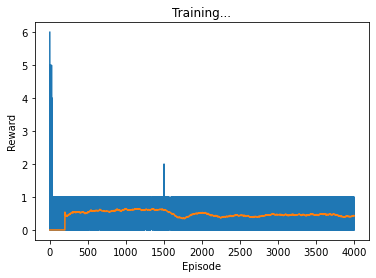

No. of false positives: 0


In [14]:
ep_rewards = []
test_rewards = []
test_data_rates = []
test_eps_iters=[]
test_minexh_rates = []
test_maxexh_rates = []
false_positives =0
policy_net.train()
test_txbdir = 0
dqneplen_list = [min_episode_length for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs))]
dqnloc_count = [0 for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs))]

#strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 2100)
outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)
train_steps = 0
em.env.goal_steps = min_episode_length
for episode in range(episodes):
 
    
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = []
    rx_dirs = []
    data_rates =[]
    #agent.current_step +=1
    train_steps +=1
    ep_count = 0
    prevep_bestaction = 0
    
    #changing from LoS to NLoS and viceversa
    if(episode == 1500):
        #strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 1000)
        #train_steps = 1
        em.env.sc_xyz = np.array([[650,300,21.5], [0,-550,21.5]])#np.array([[-100,50,21.5], [-100,-50,21.5], [-50,100,21.5],[50,100,21.5]])#np.array([[-100,50,11.5], [-100,-50,11.5], [-50,100,11.5],[50,100,11.5]])#np.array([[50,0,0], [-50,-100,0], [100,50,0],[50,-100,0]])#np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0], [100,50,0], [80,85,0], [20,30,0], [10,40,0], [80,20,0]])#np.array([[0,100,0]])#np.array([[0,100,0],[250,0,0],[-200,-150,0]]) #reflection points for now
        em.env.ch_model ='uma-nlos'#'uma-nlos' #free-space path loss model
        em.env.init_ch_model = 'uma-nlos'
        print("Los dqn count: ", dqnloc_count)
        dqnloc_count = [0 for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs))]
        #em.env.goal_steps = min_episode_length
        #max_episode_length = 3
        #print("came here")
    #3if(episode == 3000):
        #strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 1000)
        #train_steps = 1
    #    em.env.sc_xyz = np.array([])#np.array([[650,300,21.5], [0,-550,21.5]])#np.array([[-100,50,21.5], [-100,-50,21.5], [-50,100,21.5],[50,100,21.5]])#np.array([[-100,50,11.5], [-100,-50,11.5], [-50,100,11.5],[50,100,11.5]])#np.array([[50,0,0], [-50,-100,0], [100,50,0],[50,-100,0]])#np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0], [100,50,0], [80,85,0], [20,30,0], [10,40,0], [80,20,0]])#np.array([[0,100,0]])#np.array([[0,100,0],[250,0,0],[-200,-150,0]]) #reflection points for now
    #    em.env.ch_model ='uma-los'#'uma-nlos' #free-space path loss model
    #    em.env.init_ch_model = 'uma-los'
    
    #Testing the last 100 episodes
    #if((episode+1) == (episodes-100)):
    #    em.env.goal_steps= min_episode_length
    if ((episode+1) >= (episodes+100)):
        eps = 0.5#strategy.get_exploration_rate(train_steps)
        tx_num = em.env.get_txloc_ndx(np.array([[-100,-100,21.5]]))#*np.cos(58*np.pi/180)
        rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + test_txbdir]
        obs = em.test_reset(np.array([[-100,-100,21.5]]), em.env.sc_xyz, ch_randvals[episode], rbdir_ndx,test_txbdir)
        dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = min_episode_length
        #dqnloc_count[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] +=1
    else:
        eps = 0.5
        obs = em.reset(ch_randvals[episode], episode+1)
        tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
        dqnloc_count[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] +=1
        
    #if (episode ==100):
    #    for tx_loc in em.env.tx_locs:
    #        tx_num = em.env.get_txloc_ndx(tx_loc)
    #        dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = min_episode_length
    #    em.env.goal_steps = min_episode_length
    #    max_episode_length = 3
    
    em.env.goal_steps = dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]
    init_obs = obs
    temp_val = []
    ep_actions = []  
    #rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * self.obs_space.nvec[3] + test_txbdir]
    
    #ep_actions.append(em.env.rbdir_ndx)
    #init_randaction = em.env.rbdir_ndx
    policy_net.eval()
    with torch.no_grad():
        action_probs = policy_net(obs).detach().data.cpu().numpy()[0]  
    policy_net.train()
    actions= np.argsort(action_probs)[::-1]

    em.env.action_list = []
    em.env.action_list.append(em.env.rbdir_ndx)

    selected_actions = []
    selected_actions.append(actions[0])
    ep_actions.append(actions[0])
    
    #Re-collect the previous stored best dqn action for the TXlocation
    #em.env.prev_bestaction#
    tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    prevep_bestaction = actions[0]#em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]
    
    #Store the current best dqn action for the episode
    tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    #em.env.dqnbestbeam_ndxlist[em.env.tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = actions[0]

    nbour_len = 0
    if (em.env.goal_steps % 2 == 0):
        nbour_len = int((em.env.goal_steps)/2)+1
    else:
        nbour_len = int((em.env.goal_steps)/2)+1
    for i in range(1,nbour_len):
        if ((actions[0]-i) < 0):
            selected_actions.append(em.env.N_rx+actions[0]-i)
            ep_actions.append(em.env.N_rx+actions[0]-i)
        else:
            selected_actions.append(actions[0]-i)
            ep_actions.append(actions[0]-i)
        if((i+1)<nbour_len) or (not(em.env.goal_steps % 2 == 0)):
        #if(len(selected_actions) < (em.env.goal_steps)):
            #if ((actions[0]+i) > (em.env.N_rx-1)):
            #    selected_actions.append(actions[0]+i -em.env.N_rx)
            #    ep_actions.append(actions[0]+i -em.env.N_rx)
            #else:
            selected_actions.append((actions[0]+i) % em.env.N_rx)
            ep_actions.append((actions[0]+i) % em.env.N_rx)
        #else:
        #    selected_actions.append((actions[0]+i) % em.env.N_rx)
        #    ep_actions.append((actions[0]+i) % em.env.N_rx)

    em.env.reward_list = []
    em.env.reward_list.append(float(np.around(1.0, decimals=2)))

    #tx_dirs.append((em.env.tx_bdir[0]*(180/np.pi), em.env.tx_bdir[1]))
    #rx_dirs.append((em.env.rx_bdir[0]*(180/np.pi), em.env.rx_bdir[1]))
    #data_rates.append(em.env.rate)
    

    memory = ReplayBuffer(available_actions, em.env.goal_steps, em.env.goal_steps, seed, device)
    #memory.memory = em.env.goal_steps
    #memory.batch_size = em.env.goal_steps
    #print("TX Location: {}, Goal steps: {}, init_randaction: {},ep_actions: {}, prevep_bestaction: {}".format(em.env.tx_loc, em.env.goal_steps, init_randaction, ep_actions,prevep_bestaction))
    if PRIORITIZED_REPLAY:
        beta = beta_strategy.get_exploration_rate(train_steps)
    temp_actions = []
    temp_rewards = []
    temp_rates = []
    temp_bestrates = []
    rwd_action = -1
    notconv_flag = False
    for i in range(len(selected_actions)):
        
        #print(action)
        action = selected_actions[i]
        action = torch.tensor(np.array([action]), dtype=torch.long).to(device)
        next_obs, reward, done, _ = em.step(action)
        if(i== 0) and (reward.item() == -1.0):
            notconv_flag = True 
        if(reward.item() == 1.0):
            rwd_action = action.item()
        em.env.action_list.append(action.item())
        em.env.reward_list.append(float(np.around(reward.item(), decimals=2)))
        tx_dirs.append((em.env.tx_bdir[0]*(180/np.pi), em.env.tx_bdir[1]))
        rx_dirs.append((em.env.rx_bdir[0]*(180/np.pi), em.env.rx_bdir[1]))
        data_rates.append(em.env.rate)

        ep_rwd += reward.item()
        
        min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,_,_ = em.env.get_minmax_exhrate(ch_randvals[episode])
        
        next_qactionvals = target_net(next_obs).detach().data.cpu().numpy()[0]
        next_qactions= np.argsort(next_qactionvals)[::-1]
        
        next_act = torch.tensor(np.array([next_qactions[0]]), dtype=torch.long).to(device)
        #print("obs: {}, action: {}, reward: {}, next_obs:{}, next_action: {}, done: {}".format(obs, action, reward, next_obs, next_act, done))
        #print("action: {}, reward: {}".format(action, reward))
        temp_actions.append(action.item())
        temp_rewards.append(reward.item())
        temp_rates.append(em.env.rate)
        temp_bestrates.append(em.env.best_rate)
        #print("dqnactionlist: {}, Next qactionvals: {}, next_qactions: {}, selected_nextact:{}".format(agent.dqnaction_list,next_qactionvals, next_qactions, next_act))
        #print(action)
        memory.add(obs, action, reward, next_obs, next_act, done)
        
        #tensors
        #current_qval = policy_net(obs).gather(1,index=action.unsqueeze(-1))
        #next_qval = target_net(next_obs).detach().gather(1,index=next_act.unsqueeze(-1))
        #target_qval = ((next_qval*GAMMA*(~done.unsqueeze(-1))) + reward.unsqueeze(-1))
        #iter_lossval = ALPHA*(target_qval-current_qval)
        #temp_val.append(iter_lossval)
        #print(next_qval)
        obs = next_obs
        timestep +=1
#if memory.can_provide_sample():
    if PRIORITIZED_REPLAY:
        experiences = memory.sample(beta)
        observations, actions, rewards, next_observations, dones, weights, batch_indices = experiences
    else:
        experiences = memory.sample()
        observations, actions, rewards, next_observations, next_actions, dones = experiences
        weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None

    #print(observations.shape, observations.dtype)
    #print(actions.unsqueeze(-1).shape)
    current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*

    #next_q_values = target_net(next_observations).detach().max(1)[0]
    next_q_values = target_net(next_observations).detach().gather(1,index=next_actions.unsqueeze(-1))#min(1)[0]
    #next_q_actionvals = target_net(next_observations).detach().data.cpu().numpy()[0]
    #next_qactions = np.argsort(next_q_actionvals)[::-1]
    #for i in range(len(next_qactions)):
    #    if next_qactions[i] not in agent.dqnaction_list:

    target_q_values = ((next_q_values*GAMMA*(~dones.unsqueeze(-1))) + rewards.unsqueeze(-1))
    #print(current_q_values.size())
    #print(target_q_values.size())
    #print(dones.unsqueeze(-1).size())
    #print(next_actions.size(), actions.size(), next_q_values.size(), rewards.unsqueeze(-1).size())
    
    #ep_loss = (1-ALPHA)*torch.ones(loss.size()).to(device)+ ALPHA*loss
  #  td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
    #ep_loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.float()-current_q_values),  reduction='sum')
    #loss = F.l1_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction=None)
    #loss = F.cross_entropy(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction='mean')
    #loss = F.cross_entropy(current_q_values, target_q_values.unsqueeze(1).long(),  reduction='mean')
    #print(target_q_values.float()-current_q_values)
    #weighted_loss = torch.mean(weights*loss)
    #print("loss: ", loss)
    #loss = ALPHA*loss
    #ep_loss += weighted_loss.item()
 #   ep_loss = loss.item()
    #ep_lossval = torch.cat(temp_val, dim=0)
    #print(temp_val, temp_val.size())
    #ep_lossval = torch.tensor(ep_lossarr,dtype=torch.float32).to(device)

    #ep_loss = torch.sum(ep_lossval, dim=0)
    #print(ep_lossval,ep_loss.item())
    #loss = F.mse_loss(torch.zeros(ep_lossval.size()).to(device), ep_lossval, reduction='sum')
    optimizer.zero_grad()
    ep_loss = F.mse_loss(current_q_values, target_q_values.float(), reduction='sum')
    #weighted_loss.backward()
    ep_loss.backward()
    #loss.backward()
    optimizer.step()

    #if PRIORITIZED_REPLAY:
    #    comp_errors = np.array([x[0] for x in td_errors.cpu().data.numpy()])
    #    new_priorities = np.abs(comp_errors) + 1e-6
        #print(new_priorities)
    #    memory.update_priorities(batch_indices.cpu().data.numpy(), new_priorities)

    #Update the policy network
    if episode % UPDATE_EVERY == 0:
        target_net.load_state_dict(policy_net.state_dict())
    #for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
    #    target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)

    #if memory.can_provide_sample():
    
    

    tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    policy_net.eval()
    with torch.no_grad():
        action_probs = policy_net(init_obs).detach().data.cpu().numpy()[0]  
    policy_net.train()
    bestaction= np.argsort(action_probs)[::-1][0]
    #em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = bestaction
    
    print("TX Location: {}, Tx dir:{}, Goal steps: {}, ep_actions: {}, prevep_bestaction: {}".format(em.env.tx_loc, em.env.txdir_ndx, em.env.goal_steps, ep_actions,prevep_bestaction))

    #if (ep_rwd > 1.0):
    for act, rwd,rate, best_rate in zip(temp_actions, temp_rewards, temp_rates, temp_bestrates):
        print("action: {}, reward: {}, rate: {}, best_rate: {}".format(act, rwd, rate, best_rate))
    #bestaction = #em.env.best_action#em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]
    #print(em.env.best_rate)
    
    
    if not(prevep_bestaction == bestaction):
        em.env.goal_steps = min(em.env.goal_steps + episode_delta, max_episode_length)
        dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = em.env.goal_steps
    #if (prevep_bestaction == bestaction) and (not(rwd_action == bestaction)):
    if notconv_flag:
        print("tx_loc:{}, tx-dir:{} not converged until episode: {}".format(em.env.tx_loc, em.env.txdir_ndx, episode+1))
        
    ep_rewards.append(ep_rwd)
    moving_avg_rwd = get_moving_average(100, ep_rewards)
    #if (ep_rwd > 1.0):
    print('Episode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, current_best action: {}, ep_len: {}, TXloc: {}, ep_loss: {}\n\n'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], bestaction, em.env.rbdir_count, em.env.tx_loc, ep_loss.item()), end="\r")
    #if((episode+1) < (episodes-100)):
    #    tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
        #em.env.dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.rbdir_count)
        #em.env.dqnepaction_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.action_list)
        #em.env.dqnepsilon_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(eps)
        #em.env.dqnactionflag_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(agent.actionflag_list)
        #em.env.dqnactionrwd_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.reward_list)

        #if((em.env.rbdir_count-1) == em.env.goal_steps):
        #    em.env.dqneplen_counter[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] += 1

    #if(((episode+1) >= 6000) or (3000 <= (episode+1)<=3500)):
    if((episode+1) >= (episodes+100)):

        test_data_rates.append(max(data_rates))
        test_eps_iters.append(timestep)
        test_minexh_rates.append(min_exh_rate)
        test_maxexh_rates.append(max_exh_rate)

        #if (timestep > 3):
        #    if(timestep >=8):
        #        false_positives +=1
        #if (min_exh_rate == max_exh_rate):
        print("\ntest_eps: {0}, eps_rwd: {1}".format(episode+1, ep_rwd))
        print("TX loc: {}".format(em.env.tx_loc))
        print("SC_xyz: {}".format(em.env.sc_xyz))
        print("TX dirs: ", tx_dirs)
        print("RX dirs: ", rx_dirs)
        print("data rates: {}".format(data_rates))
        print("min exh_rate: {}, min_action_ndx: {}, beamset val: ({},{})".format(min_exh_rate, min_action_ndx, em.env.BeamSet[min_action_ndx][0]*180/np.pi,em.env.BeamSet[min_action_ndx][1]))
        print("max exh_rate: {}, max_action_ndx: {}, beamset val: ({},{})\n".format(max_exh_rate, max_action_ndx, em.env.BeamSet[max_action_ndx][0]*180/np.pi, em.env.BeamSet[max_action_ndx][1]))

    timestep = 0
        
            
    # update tqdm bar
    outer.update(1)
    
torch.save(policy_net.state_dict(), 'checkpoint.pth')
plot(ep_rewards, 200, test_rewards) 
print("No. of false positives: {}".format(false_positives))

In [15]:
a = torch.rand(1, 3, 4)
print(a.shape)
b = torch.rand(3, 4)
print(b.shape)
b = b.unsqueeze(0)
print(b.shape)
c = torch.cat([a, b], dim=0)
print(c.shape)
print(torch.zeros(1,1, dtype=torch.float).size())

torch.Size([1, 3, 4])
torch.Size([3, 4])
torch.Size([1, 3, 4])
torch.Size([2, 3, 4])
torch.Size([1, 1])


In [16]:
print(dqnloc_count)

[260, 271, 262, 285, 295, 265, 285, 280, 297]


In [17]:
#test a particular TXlocation
tx_num = em.env.get_txloc_ndx(np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180)+50,11.5]]))
print(tx_num)
rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + test_txbdir]
obs = em.test_reset(np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180)+50,11.5]]), em.env.sc_xyz, ch_randvals[episode], rbdir_ndx,test_txbdir)
dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = min_episode_length

em.env.goal_steps = dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]
init_obs = obs
temp_val = []
ep_actions = []  
#rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * self.obs_space.nvec[3] + test_txbdir]
#Re-collect the previous stored best dqn action for the TXlocation
#em.env.prev_bestaction#
tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
prevep_bestaction = em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]#em.env.rbdir_ndx
#ep_actions.append(em.env.rbdir_ndx)
init_randaction = em.env.rbdir_ndx
policy_net.eval()
with torch.no_grad():
    action_probs = policy_net(obs).detach().data.cpu().numpy()[0]  
policy_net.train()
actions= np.argsort(action_probs)[::-1]

em.env.action_list = []
em.env.action_list.append(em.env.rbdir_ndx)

selected_actions = []
selected_actions.append(actions[0])
ep_actions.append(actions[0])

#Store the current best dqn action for the episode
tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
em.env.dqnbestbeam_ndxlist[em.env.tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = actions[0]

nbour_len = 0
if (em.env.goal_steps % 2 == 0):
    nbour_len = int(em.env.goal_steps/2)+1
else:
    nbour_len = int((em.env.goal_steps)/2)+1
for i in range(1,nbour_len):
    if ((actions[0]-i) < 0):
        selected_actions.append(em.env.N_rx+actions[0]-i)
        ep_actions.append(em.env.N_rx+actions[0]-i)
    else:
        selected_actions.append(actions[0]-i)
        ep_actions.append(actions[0]-i)
    if((i+1)<nbour_len) or (not(em.env.goal_steps % 2 == 0)):
        #if ((actions[0]+i) > (em.env.N_rx-1)):
        #    selected_actions.append(actions[0]+i -em.env.N_rx)
        #    ep_actions.append(actions[0]+i -em.env.N_rx)
        #else:
        selected_actions.append((actions[0]+i) % em.env.N_rx)
        ep_actions.append((actions[0]+i) % em.env.N_rx)
    #else:
    #    selected_actions.append((actions[0]+i) % em.env.N_rx)
    #    ep_actions.append((actions[0]+i) % em.env.N_rx)

em.env.reward_list = []
em.env.reward_list.append(float(np.around(1.0, decimals=2)))

tx_dirs.append((em.env.tx_bdir[0]*(180/np.pi), em.env.tx_bdir[1]))
rx_dirs.append((em.env.rx_bdir[0]*(180/np.pi), em.env.rx_bdir[1]))
data_rates.append(em.env.rate)
print("TX Location: {}, Goal steps: {}, init_randaction: {},ep_actions: {}, prevep_bestaction: {}".format(em.env.tx_loc, em.env.goal_steps, init_randaction, ep_actions,prevep_bestaction))



9


IndexError: list index out of range

ep_rewards = []
test_rewards = []
test_data_rates = []
test_eps_iters=[]
test_minexh_rates = []
test_maxexh_rates = []
false_positives =0
policy_net.train()
test_txbdir = 0

strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 4100)
outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)
train_steps = 0
for episode in range(episodes):
 
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = []
    rx_dirs = []
    data_rates =[]
    #agent.current_step +=1
    train_steps +=1
    
    
    #changing from LoS to NLoS and viceversa
    
    if((episode+1) == (episodes-1000)):
        strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 4100)
        train_steps = 1
    if ((episode+1) >= (episodes-1000)):    
        #strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 4100)
        eps = strategy.get_exploration_rate(train_steps)
        #print(eps, train_steps)
        agent.dqnaction_list = []
        agent.action_flag =-1
        em.env.sc_xyz = np.array([[-100,50,21.5], [-100,-50,21.5], [-50,100,21.5],[50,100,21.5]])#np.array([[-100,50,11.5], [-100,-50,11.5], [-50,100,11.5],[50,100,11.5]])#np.array([[50,0,0], [-50,-100,0], [100,50,0],[50,-100,0]])#np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0], [100,50,0], [80,85,0], [20,30,0], [10,40,0], [80,20,0]])#np.array([[0,100,0]])#np.array([[0,100,0],[250,0,0],[-200,-150,0]]) #reflection points for now
        em.env.ch_model ='uma-nlos'#'uma-nlos' #free-space path loss model
        em.env.init_ch_model = 'uma-nlos'
        em.env.goal_steps = 4
        obs = em.reset(ch_randvals[episode], eps)
        
        if(eps <= 0.5):
            agent.action_flag = 1
        #    agent.dqnaction_list.append(em.env.rbdir_ndx)
        else:
            agent.action_flag = 0
            
        em.env.action_list = []
        em.env.action_list.append(em.env.rbdir_ndx)
        agent.randaction_list = []
        agent.actionflag_list = []
        agent.randaction_list.append(em.env.rbdir_ndx)
        agent.actionflag_list.append(agent.action_flag)
        em.env.reward_list = []
        em.env.reward_list.append(float(np.around(1.0, decimals=2)))
        #em.env.temprwd_list = []
        #em.env.temprwd_list.append(float(np.around(1.0, decimals=2)))    
    
    elif ((episode+1) >= (episodes-100)):
        eps = strategy.get_exploration_rate(train_steps)
        agent.dqnaction_list = []
        agent.action_flag =-1
        tx_num = em.env.get_txloc_ndx(np.array([[-100*np.cos(53*np.pi/180),-100*np.sin(53*np.pi/180),21.5]]))
        rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + test_txbdir]
        rbdir_ndx = rbdir_ndx_tensor.item()
        #rbdir_ndx = 0
        
        obs = em.test_reset(np.array([[-100*np.cos(53*np.pi/180),-100*np.sin(53*np.pi/180),21.5]]), em.env.sc_xyz, ch_randvals[episode], rbdir_ndx,test_txbdir)
        test_txbdir = (test_txbdir + 1) % em.env.obs_space.nvec[3]
        em.env.reward_list = []
        em.env.reward_list.append(float(np.around(1.0, decimals=2)))
        #em.env.temprwd_list = []
        #em.env.temprwd_list.append(float(np.around(1.0, decimals=2)))
        
    else:
        eps = strategy.get_exploration_rate(train_steps)
        agent.dqnaction_list = []
        #tx_num = self.get_txloc_ndx(np.array([[-100,-100,21.5]]))
        #rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * self.obs_space.nvec[3] + test_txbdir]        
        agent.action_flag =-1
        obs = em.reset(ch_randvals[episode], eps)
        if(eps <= 0.5):
            agent.action_flag = 1
        #    agent.dqnaction_list.append(em.env.rbdir_ndx)
        else:
            agent.action_flag = 0
            
        em.env.action_list = []
        em.env.action_list.append(em.env.rbdir_ndx)
        agent.randaction_list = []
        agent.actionflag_list = []
        agent.randaction_list.append(em.env.rbdir_ndx)
        agent.actionflag_list.append(agent.action_flag)
        em.env.reward_list = []
        em.env.reward_list.append(float(np.around(1.0, decimals=2)))
        #em.env.temprwd_list = []
        #em.env.temprwd_list.append(float(np.around(1.0, decimals=2)))
        
    
    if PRIORITIZED_REPLAY:
        beta = beta_strategy.get_exploration_rate(train_steps)
    
    while True:
        tx_dirs.append((em.env.tx_bdir[0]*(180/np.pi), em.env.tx_bdir[1]))
        rx_dirs.append((em.env.rx_bdir[0]*(180/np.pi), em.env.rx_bdir[1]))
        data_rates.append(em.env.rate)

        agent.action_flag = -1
        action = agent.act(obs, policy_net, eps, 8)
        agent.actionflag_list.append(agent.action_flag)
        #print(action)
        next_obs, reward, done, _ = em.step(action)
        em.env.action_list.append(action.item())
        em.env.reward_list.append(float(np.around(reward.item(), decimals=2)))
        #em.env.temprwd_list.append(float(np.around(temp_rwd.item(), decimals=2)))
        #em.env.epsilon_list.append(eps)
        
        #agent.step(obs, action, reward, next_obs, done)
        ep_rwd += reward.item()
        
        min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,_,_ = em.env.get_minmax_exhrate(ch_randvals[episode])
        
        next_qactionvals = target_net(next_obs).detach().data.cpu().numpy()[0]
        next_qactions= np.argsort(next_qactionvals)[::-1]
        
        #for a in next_qactions:
        #    if a not in agent.dqnaction_list:
        #        next_qact = a
        #        break
        next_act = torch.tensor(np.array([next_qactions[0]]), dtype=torch.long).to(device)
        #print("obs: {}, action: {}, reward: {}, next_obs:{}, next_action: {}, done: {}".format(obs, action, reward, next_obs, next_act, done))
        #print("dqnactionlist: {}, Next qactionvals: {}, next_qactions: {}, selected_nextact:{}".format(agent.dqnaction_list,next_qactionvals, next_qactions, next_act))
        #print(action)
        memory.add(obs, action, reward, next_obs, next_act, done)
        
        #current_qval = policy_net(obs).gather(1,index=action.unsqueeze(-1))
        #print(current_qval, current_qval.size())
        
        #print(next_qact, action)
        #next_qval = target_net(next_obs).detach().gather(1,index=next_qact.unsqueeze(-1))
        #print(next_qval)
        
        
        obs = next_obs
        
        if memory.can_provide_sample():

            if PRIORITIZED_REPLAY:
                experiences = memory.sample(beta)
                observations, actions, rewards, next_observations, dones, weights, batch_indices = experiences
            else:
                experiences = memory.sample()
                observations, actions, rewards, next_observations, next_actions, dones = experiences
                weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None

            #print(observations.shape, observations.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*

            #next_q_values = target_net(next_observations).detach().max(1)[0]
            next_q_values = target_net(next_observations).detach().gather(1,index=next_actions.unsqueeze(-1))#min(1)[0]
            #next_q_actionvals = target_net(next_observations).detach().data.cpu().numpy()[0]
            #next_qactions = np.argsort(next_q_actionvals)[::-1]
            #for i in range(len(next_qactions)):
            #    if next_qactions[i] not in agent.dqnaction_list:

            target_q_values = ((next_q_values*GAMMA*(~dones.unsqueeze(-1))) + rewards.unsqueeze(-1))
            #print(current_q_values.size())
            #print(target_q_values.size())
            #print(dones.unsqueeze(-1).size())
            #print(next_actions.size(), actions.size(), next_q_values.size(), rewards.unsqueeze(-1).size())
            #loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
            loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.float()-current_q_values),  reduction='sum')
            #loss = F.l1_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction=None)
            #loss = F.cross_entropy(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction='mean')
            #loss = F.cross_entropy(current_q_values, target_q_values.unsqueeze(1).long(),  reduction='mean')
            #print(target_q_values.float()-current_q_values)
            #weighted_loss = torch.mean(weights*loss)
            #print("loss: ", loss)
            #loss = ALPHA*loss
            #ep_loss += weighted_loss.item()
            ep_loss = loss.item()

            optimizer.zero_grad()
            #weighted_loss.backward()
            loss.backward()
            optimizer.step()

            if PRIORITIZED_REPLAY:
                comp_errors = np.array([x[0] for x in td_errors.cpu().data.numpy()])
                new_priorities = np.abs(comp_errors) + 1e-6
                #print(new_priorities)
                memory.update_priorities(batch_indices.cpu().data.numpy(), new_priorities)

            #Update the policy network
            #if episode % UPDATE_EVERY == 0:
            #    target_net.load_state_dict(policy_net.state_dict())
            for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
                target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
        
        timestep +=1
        if done:
        
            ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(100, ep_rewards)
            print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, , ep_len: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], em.env.rbdir_count, ep_loss), end="\r")
            #plot(episode_rewards, 100)
            if((episode+1) < (episodes-100)):
                tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
                em.env.dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.rbdir_count)
                em.env.dqnepaction_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.action_list)
                em.env.dqnepsilon_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(eps)
                em.env.dqnactionflag_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(agent.actionflag_list)
                em.env.dqnactionrwd_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.reward_list)
                #em.env.dqntemprwd_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.temprwd_list)
                
                if((em.env.rbdir_count-1) == em.env.goal_steps):
                    em.env.dqneplen_counter[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] += 1
        
            #if(((episode+1) >= 6000) or (3000 <= (episode+1)<=3500)):
            if((episode+1) >= (episodes-100)):
                
                test_data_rates.append(max(data_rates))
                test_eps_iters.append(timestep)
                test_minexh_rates.append(min_exh_rate)
                test_maxexh_rates.append(max_exh_rate)
                
                #if (timestep > 3):
                #    if(timestep >=8):
                #        false_positives +=1
                #if (min_exh_rate == max_exh_rate):
                print("\ntest_eps: {0}, eps_rwd: {1}".format(episode+1, ep_rwd))
                print("TX loc: {}".format(em.env.tx_loc))
                print("SC_xyz: {}".format(em.env.sc_xyz))
                print("TX dirs: ", tx_dirs)
                print("RX dirs: ", rx_dirs)
                print("data rates: {}".format(data_rates))
                print("min exh_rate: {}, min_action_ndx: {}, beamset val: ({},{})".format(min_exh_rate, min_action_ndx, em.env.BeamSet[min_action_ndx][0]*180/np.pi,em.env.BeamSet[min_action_ndx][1]))
                print("max exh_rate: {}, max_action_ndx: {}, beamset val: ({},{})\n".format(max_exh_rate, max_action_ndx, em.env.BeamSet[max_action_ndx][0]*180/np.pi, em.env.BeamSet[max_action_ndx][1]))
                
            timestep = 0
            break
            
        
    
    '''    
    if ((episode == 0) or (episode+1) == 3100) or (((episode+1) > 3100) and ((train_steps) % (TEST_EVERY) == 0)):
        #test some episodes to check the performance
        policy_net.eval()
        test_ep_rwds = []
        for test_eps in range(test_episodes):
            obs = em.test_reset(test_loc, em.env.action_space.sample(), em.env.sc_xyz, ch_randvals[episode+test_eps+1])
            test_score=0
            tx_dirs = []
            rx_dirs = []
            data_rates =[]
            step = 0
            done = False
            while not done:
                action = policy_net(obs).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
                #print("timestep: ",step, policy_net(obs),policy_net(obs).size(), action)
                tx_dirs.append(em.env.tx_bdir*(180/np.pi))
                rx_dirs.append(em.env.rx_bdir*(180/np.pi))
                data_rates.append(em.env.rate)
                next_obs, reward, done, _ = em.step(action)
                step+=1
                print("\ntstep: {0}, obs: {1}, action: {2}, next_obs: {3}, rwd: {4}, done: {5}".format(step, obs.cpu().data.numpy(), action.cpu().data.numpy(), next_obs.cpu().data.numpy(), reward.item(), done.item()))
                test_score+=reward.item()
                obs = next_obs
            
            print("test_eps: {0}, eps_rwd: {1}".format(test_eps+1, test_score))
            print("TX loc: {}".format(em.env.tx_loc))
            print("TX dirs: ", tx_dirs)
            print("RX dirs: ", rx_dirs)
            print("data rates: {}".format(data_rates))
            min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,_,_ = em.env.get_minmax_exhrate(ch_randvals[episode+test_eps+1])
            print("min exh_rate: {}, min_action_ndx: {}".format(min_exh_rate, min_action_ndx))
            print("max exh_rate: {}, max_action_ndx: {}".format(max_exh_rate, max_action_ndx))
            
            test_ep_rwds.append(test_score)
            test_rewards.append(test_score)
            test_data_rates.append(data_rates[-1])
            test_minexh_rates.append(min_exh_rate)
            test_maxexh_rates.append(max_exh_rate)
            
        print("Average test_ep_score: {}\n".format(np.mean(test_ep_rwds)))
        policy_net.train()
        #agent.current_step=0
        train_steps = 0
        strategy =EpsilonGreedyStrategy(0.5, eps_end, 0.997)#0.1
    else:
        test_rewards.append(0)
        test_data_rates.append(0)
        test_minexh_rates.append(0)
        test_maxexh_rates.append(0)
    '''
    # update tqdm bar
    outer.update(1)
    
torch.save(policy_net.state_dict(), 'checkpoint.pth')

#timer.finish()
plot(ep_rewards, 200, test_rewards)
print("No. of false positives: {}".format(false_positives))

In [ ]:
fig=plt.figure()
min_ndx=0
max_ndx=500
plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.show()
print(np.mean(test_eps_iters), len(test_eps_iters))

In [ ]:
print(em.env.ch_model)
print(em.env.sc_xyz)

test_net = QNetwork(state_size, available_actions, seed).to(device)
test_net.load_state_dict(torch.load('checkpoint.pth'))
test_net.eval()
tx_loc = np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180),21.5]])
tbdir_ndx = 0
rbdir_ndx = 0
norm_tx_xloc = np.array([(tx_loc[0][0]) / 1000])  # np.max(self.rx_xcov)])#np.array([(self.tx_loc[0][0]+np.max(self.rx_xcov))/(np.max(self.rx_xcov))])#-np.min(self.rx_xcov))])
norm_tx_yloc = np.array([(tx_loc[0][1]) / 1000])  # max(np.max(self.rx_ycov),1)])#np.array([(self.tx_loc[0][1] + np.max(self.rx_ycov)) / (np.max(self.rx_ycov))])# - np.min(self.rx_ycov))])
norm_tx_zloc = np.array([(tx_loc[0][2]) / 22.5])
norm_tx_ndx = np.array([tbdir_ndx / em.env.obs_space.nvec[3]])
norm_rx_ndx = np.array([rbdir_ndx / em.env.action_space.n])
obs = np.array([np.concatenate((norm_rx_ndx, norm_tx_ndx, norm_tx_xloc, norm_tx_yloc,norm_tx_zloc), axis=0)])

obs_tensor = torch.tensor(obs, device=device, dtype=torch.float32)
#print(np.sort(test_net(obs_tensor).data.cpu().numpy()[0]))

In [ ]:
fig = plt.figure(figsize=[9, 6])
min_ndx=24
max_ndx=48
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')

plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
plt.legend(['learnt rate','min exhrate', 'max exhrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.show()

In [ ]:
min_ndx=60
max_ndx=80
print(test_data_rates[min_ndx:max_ndx])
print(test_maxexh_rates[min_ndx:max_ndx])
print(em.env.sc_xyz)
print(em.env.ch_model)
print(em.env.init_ch_model)

In [ ]:
print(test_data_rates[69])
print([(x[0]*180/np.pi, x[1]) for x in em.env.BeamSet])
#print(em.env.BeamSet[9])

In [ ]:
print(em.env.dqnobs_counter)
print(len(em.env.dqnobs_counter))
print(np.mean(em.env.dqnobs_counter))

In [ ]:
print(em.env.dqneplen_counter)
print(np.mean(em.env.dqneplen_counter))

In [ ]:
tx_loc = np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180),21.5]])
txdir_ndx = 0

tx_num = em.env.get_txloc_ndx(tx_loc)
obs_epiters = em.env.dqneplen_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx]

count = 0
for x,y,z,w in zip(em.env.dqnepaction_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx],em.env.dqnepsilon_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx],em.env.dqnactionflag_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx], em.env.dqnactionrwd_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx]):
    #print("episode actions: {}, eps: {}".format(x,y,z))
    temp_list =[(i,j,k) for i,j,k in zip(x,z,w)]
    count = count + 1
    if (count >2980):
        print("NLoS episode actions: {}, eps: {}".format(temp_list,y))
    elif (count >=2300 and count <2340):
        print("NLoS-random episode actions: {}, eps: {}".format(temp_list,y))
    
    elif(count > 1990 and count <= 2000):
    #    break
        print("LoS episode actions: {}, eps: {}".format(temp_list,y))
    #else:
    #    pass
    
        
#print(em.env.dqnepsilon_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx])
#fig = plt.figure(figsize=[9, 6])
#plt.plot(np.arange(len(obs_epiters)), obs_epiters, 'b')
#plt.xlabel('Episode #')
#plt.ylabel('Episode Iterations')
#plt.title('Training convergence for tx_loc:{}, txdir: {}, ep_len:{}'.format(tx_loc, (em.env.BeamSet[txdir_ndx][0]*180/np.pi,em.env.BeamSet[txdir_ndx][1]),em.env.goal_steps))
#plt.show()

In [ ]:
tx_loc = np.array([[650,-400,21.5]])
txdir_ndx = 0
#print(em.env.BeamSet[5][0]*180/np.pi)
print("tx-loc: ", tx_loc)

em.env.sc_xyz = np.array([[650,300,21.5], [0,-550,21.5]])#[-200,300,21.5], [-200,-300,21.5], [150,-400,21.5], ,[-250,-200,21.5]np.array([[-100,50,11.5], [-100,-50,11.5], [-50,100,11.5],[50,100,11.5]])#np.array([[50,0,0], [-50,-100,0], [100,50,0],[50,-100,0]])#np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0], [100,50,0], [80,85,0], [20,30,0], [10,40,0], [80,20,0]])#np.array([[0,100,0]])#np.array([[0,100,0],[250,0,0],[-200,-150,0]]) #reflection points for now
em.env.ch_model ='uma-nlos'#'uma-nlos' #free-space path loss model
em.env.init_ch_model = 'uma-nlos'
tx_num = em.env.get_txloc_ndx(tx_loc)
print(em.env.ch_model)
print(em.env.sc_xyz)
for rbdir_ndx in range(em.env.N_rx):
    obs = em.test_reset(tx_loc, em.env.sc_xyz, np.exp(1j*2*np.pi*0.6), rbdir_ndx,txdir_ndx)
    #_ = em.env.test_reset(tx_loc, txdir_ndx, rbdir_ndx,em.env.sc_xyz, np.exp(1j * 2 * np.pi * 0.6))
    print("rbdir_ndx: {}, SNR:{}, rate: {}".format(rbdir_ndx, em.env.SNR, em.env.rate))

In [ ]:
tx_loc = np.array([[650,-400,21.5]])#np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180),21.5]])
txdir_ndx = 7

#tx_num = em.env.get_txloc_ndx(tx_loc)
em.env.sc_xyz=np.array([])
em.env.ch_model ='uma-los'#'uma-nlos' #free-space path loss model
em.env.init_ch_model = 'uma-los'
print(em.env.ch_model)
print(em.env.sc_xyz)
for rbdir_ndx in range(em.env.N_rx):
    obs = em.test_reset(tx_loc, em.env.sc_xyz, np.exp(1j*2*np.pi*0.6), rbdir_ndx,txdir_ndx)
    #_ = em.env.test_reset(tx_loc, txdir_ndx, rbdir_ndx,em.env.sc_xyz, np.exp(1j * 2 * np.pi * 0.6))
    print("rbdir_ndx: {}, SNR:{}, rate: {}".format(rbdir_ndx, em.env.SNR, em.env.rate))

In [ ]:
print("angle 5: ", em.env.BeamSet[5][0]*180/np.pi)
print("angle 6: ", em.env.BeamSet[6][0]*180/np.pi)
tx_loc = np.array([[-100*np.cos(45*np.pi/180),-100*np.sin(45*np.pi/180),21.5]])
print(tx_loc)

In [ ]:
#import pickle

#memory.save('memory_checkpoint.pth')
plot(ep_rewards, 100, test_rewards)
print(ep_rewards[:100])
moving_avg_rwd = get_moving_average(100, ep_rewards[:100])
print(moving_avg_rwd)

## Test the DQN agent

In [ ]:
from Source.misc_fun.utils import var_plotbeam

print(tx_dirs)
print(rx_dirs)
for tx_ang, rx_ang in zip(tx_dirs, rx_dirs):
    tx_theta, tx_gr = var_plotbeam(tx_ang, em.env.N_tx)
    rx_theta, rx_gr = var_plotbeam(rx_ang, em.env.N_rx)
    ax1 = plt.subplot(122, projection='polar')
    ax1.plot(tx_theta, tx_gr)

    ax2 = plt.subplot(121, projection='polar')
    ax2.plot(rx_theta, rx_gr)

    plt.show()




## Display all exhaustive rate measurements from env

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

fig = plt.figure()
ax = fig.gca(projection='3d')
poly = PolyCollection(verts[:4], facecolors=['r', 'g', 'b', 'y'], alpha=0.6)
print(len(verts))
print(verts[0:2])
#print(np.array(tx_locs[:4]))
ax.add_collection3d(poly, zs=np.arange(1,5), zdir='y')

ax.set_xlabel('X (beam pairs)')
ax.set_ylabel('Y (tx_locs)')
ax.set_zlabel('Z (data rates)')
ax.set_xlim(0, 10)
ax.set_ylim(1, 5)
ax.set_zlim(10, 30)

plt.show()

In [ ]:
print(em.env.ch_model)
print(em.env.sc_xyz)
em.env.BeamSet[5][0]*180/np.pi
np.arctan(1100/200)*180/np.pi

In [ ]:
12/24, 14/24

from Source.misc_fun.utils import plotbeam

tx_theta, tx_gr = plotbeam(exh_txbeams[0]*(np.pi/180), em.env.N_tx)
rx_theta, rx_gr = plotbeam(exh_rxbeams[0]*(np.pi/180), em.env.N_rx)
ax1 = plt.subplot(122, projection='polar')
ax1.plot(tx_theta, tx_gr)

ax2 = plt.subplot(121, projection='polar')
ax2.plot(rx_theta, rx_gr)

plt.show()

